In [1]:
import pandas as pd

In [2]:
closingPrices = pd.read_csv('ClosingPrices.csv', index_col=0)
closingPrices

,MUNDRAPORT,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UNIPHOS,SESAGOA,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-04,161.20,2663.05,1544.40,1610.35,481.95,810.30,326.15,760.35,413.75,349.95,...,1234.05,621.50,1069.15,748.75,3822.35,1121.75,212.55,335.05,436.75,297.40
2010-11-05,162.30,2688.95,1549.85,1614.35,489.50,811.90,329.50,762.45,421.90,352.95,...,1244.95,623.55,1077.75,750.80,3837.45,1116.85,213.15,337.15,438.05,296.05
2010-11-08,161.40,2740.85,1555.90,1600.45,481.80,809.15,328.05,741.05,418.75,348.90,...,1269.25,633.20,1068.15,748.85,3817.65,1122.55,210.40,342.00,431.20,295.75
2010-11-09,162.25,2755.40,1562.30,1610.00,475.30,815.80,334.55,744.05,440.35,349.95,...,1269.90,641.30,1091.10,753.75,3822.30,1147.55,206.60,343.80,431.65,295.35
2010-11-10,159.90,2747.45,1543.40,1574.60,471.95,809.90,327.05,755.75,438.65,342.70,...,1302.50,637.40,1092.30,754.50,4146.75,1132.25,207.30,342.40,436.55,295.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,725.35,2517.95,671.35,3672.50,9916.65,4667.80,522.60,423.05,3650.30,935.60,...,294.00,925.60,3109.50,950.20,1461.45,6067.90,585.40,228.00,475.70,188.00
2021-04-26,730.75,2557.90,700.45,3738.85,10001.75,4736.55,527.55,418.90,3539.20,905.40,...,295.40,940.75,3100.80,962.20,1479.85,6275.90,590.65,236.65,480.30,186.40
2021-04-27,749.15,2574.35,699.55,3785.50,10091.35,4865.05,534.30,420.35,3541.20,912.40,...,301.50,977.75,3132.00,969.25,1495.10,6326.80,597.45,243.35,485.05,188.15


In [3]:
closingPrices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2597 entries, 2010-11-04 to 2021-04-29
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MUNDRAPORT  2597 non-null   float64
 1   ASIANPAINT  2597 non-null   float64
 2   AXISBANK    2597 non-null   float64
 3   BAJAJ-AUTO  2597 non-null   float64
 4   BAJAJFINSV  2597 non-null   float64
 5   BAJFINANCE  2597 non-null   float64
 6   BHARTIARTL  2597 non-null   float64
 7   BPCL        2597 non-null   float64
 8   BRITANNIA   2597 non-null   float64
 9   CIPLA       2597 non-null   float64
 10  COALINDIA   2597 non-null   float64
 11  DRREDDY     2597 non-null   float64
 12  EICHERMOT   2597 non-null   float64
 13  GAIL        2597 non-null   float64
 14  GRASIM      2597 non-null   float64
 15  HCLTECH     2597 non-null   float64
 16  HDFC        2597 non-null   float64
 17  HDFCBANK    2597 non-null   float64
 18  HEROHONDA   2597 non-null   float64
 19  HINDALCO    2597 

In [4]:
print(closingPrices.isnull().sum())

MUNDRAPORT    0
ASIANPAINT    0
AXISBANK      0
BAJAJ-AUTO    0
BAJAJFINSV    0
BAJFINANCE    0
BHARTIARTL    0
BPCL          0
BRITANNIA     0
CIPLA         0
COALINDIA     0
DRREDDY       0
EICHERMOT     0
GAIL          0
GRASIM        0
HCLTECH       0
HDFC          0
HDFCBANK      0
HEROHONDA     0
HINDALCO      0
HINDUNILVR    0
ICICIBANK     0
INDUSINDBK    0
INFOSYSTCH    0
IOC           0
ITC           0
JSWSTEEL      0
KOTAKBANK     0
LT            0
MARUTI        0
M&M           0
NESTLEIND     0
NTPC          0
ONGC          0
POWERGRID     0
RELIANCE      0
SBIN          0
SHREECEM      0
SUNPHARMA     0
TATAMOTORS    0
TATASTEEL     0
TCS           0
TECHM         0
TITAN         0
ULTRACEMCO    0
UNIPHOS       0
SESAGOA       0
WIPRO         0
ZEEL          0
dtype: int64


In [5]:
train_data = closingPrices.loc['2011-01-01':'2019-12-31',]
test_data = closingPrices.loc['2020-01-01':'2020-12-31',]

In [6]:
train_data

,MUNDRAPORT,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UNIPHOS,SESAGOA,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,145.05,2874.55,1367.65,1476.50,470.40,704.75,359.35,659.95,409.35,372.50,...,1308.45,704.05,1158.05,711.65,3686.85,1087.70,169.10,340.10,483.05,144.55
2011-01-04,148.55,2836.20,1347.95,1429.80,468.20,700.40,356.40,653.55,409.60,379.25,...,1298.40,694.70,1144.75,744.60,3657.95,1090.20,166.95,335.80,484.65,143.05
2011-01-05,157.60,2880.50,1310.90,1374.50,464.75,697.50,349.00,632.55,410.00,376.35,...,1282.80,680.95,1158.95,728.55,3641.25,1072.55,163.40,342.00,485.65,140.40
2011-01-06,154.95,2849.50,1305.85,1327.85,454.50,688.75,353.20,618.75,401.65,363.60,...,1261.00,683.30,1171.70,729.85,3579.40,1010.85,161.75,344.20,486.35,137.80
2011-01-07,147.25,2775.75,1280.65,1316.60,445.85,659.65,338.50,616.95,395.80,357.00,...,1190.20,661.25,1142.65,707.70,3412.25,987.75,160.60,331.85,476.95,135.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,368.60,1803.45,740.65,3226.75,9294.85,4139.50,457.15,477.80,3091.05,478.70,...,175.50,463.00,2215.60,772.05,1204.10,4097.35,569.15,148.05,252.25,297.25
2019-12-26,363.65,1809.60,736.50,3230.05,9350.10,4187.10,447.55,477.20,3062.30,474.15,...,174.60,467.90,2201.95,770.40,1192.50,4062.75,569.45,150.70,250.30,297.30
2019-12-27,363.70,1812.25,760.15,3241.95,9443.15,4252.65,455.10,490.95,3042.10,481.10,...,176.15,469.50,2198.50,780.20,1191.45,4055.60,580.25,151.75,247.55,299.00


In [7]:
test_data

,MUNDRAPORT,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UNIPHOS,SESAGOA,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,377.65,1793.20,748.70,3150.10,9378.45,4231.30,453.30,491.65,3039.65,475.90,...,184.45,467.75,2167.60,762.10,1154.75,4065.00,588.25,154.60,247.70,288.65
2020-01-02,383.15,1790.65,756.95,3121.00,9505.60,4246.05,455.20,487.55,3053.40,473.50,...,193.75,484.85,2157.65,766.05,1155.60,4244.80,595.45,159.45,248.30,289.60
2020-01-03,382.50,1751.40,742.95,3072.05,9345.85,4193.45,455.10,483.50,3038.80,469.95,...,191.10,483.70,2200.65,775.10,1139.70,4219.20,590.75,157.75,251.10,273.70
2020-01-06,380.20,1707.15,723.25,3037.65,9042.70,3996.70,449.65,469.15,3022.05,466.75,...,185.65,473.25,2200.45,770.40,1158.60,4157.10,584.95,150.55,252.15,261.50
2020-01-07,384.80,1724.40,725.75,3037.95,9095.65,4007.65,445.10,461.00,3036.60,468.60,...,184.70,476.10,2205.85,777.10,1159.95,4242.10,595.05,156.00,255.20,267.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,478.55,2648.25,610.20,3374.75,8992.55,5184.90,517.30,377.55,3618.25,833.20,...,175.95,622.30,2909.35,947.25,1495.90,5044.75,449.40,162.85,382.20,217.30
2020-12-28,483.55,2683.90,617.65,3414.70,8995.05,5204.10,521.60,382.75,3603.55,830.15,...,186.35,632.65,2929.40,947.10,1543.55,5142.15,453.40,163.45,382.90,220.15
2020-12-29,483.40,2696.80,630.20,3431.55,8976.05,5200.50,520.25,381.50,3593.30,827.95,...,183.45,632.20,2930.50,965.65,1540.10,5146.75,454.70,160.10,385.00,218.15


In [8]:
variables = []
column = list(closingPrices.columns)
for i in range(len(column)):
    for j in range(i+1, len(column)):
        variables.append((column[i],column[j]))

In [9]:
len(variables)

1176

In [10]:
import numpy as np
import networkx as nx
from bayesian_networks import GaussianBayesianNetwork

class BayesianNetwork:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        self.CPDs = {}

    def fit(self, data):
        for node in self.nodes:
            self.CPDs[node] = {}
            print(self.edges)
            for parent in self.edges[node]:
                self.CPDs[node][parent] = {}
                for value in data[node].unique():
                    self.CPDs[node][parent][value] = np.count_nonzero(data[node] == value) / np.count_nonzero(data[parent] == self.edges[node][parent])

    def predict(self, evidence):
        probabilities = {}
        for node in self.nodes:
            if node in evidence:
                probabilities[node] = evidence[node]
            else:
                probabilities[node] = np.sum([self.CPDs[node][parent][value] * probabilities[parent] for parent, value in self.edges[node].items()])

        return probabilities

data = closingPrices.copy()
print(type(data))

G = nx.DiGraph()
column = list(closingPrices.columns)
for i in range(len(column)):
    G.add_node(column[i])
    for j in range(i+1, len(column)):
        G.add_edge(column[i],column[j])
       
BN = BayesianNetwork(G.nodes(), G.edges())
BN.fit(data)

ModuleNotFoundError: No module named 'bayesian_networks'

: 

In [ ]:
# import numpy as np
# import pgmpy 

# def estimate_gaussian_parameters(data):
#     mean = np.mean(data)
#     variance = np.var(data)
#     return mean, variance

# mean_and_variances = {}
# for node in G.nodes():
#     mean, variance = estimate_gaussian_parameters(data[node])
#     mean_and_variances[node] = (mean, variance)
    
import numpy as np
import scipy.sparse as sp
import pyspark as spark

# Create a Spark context
sc = spark.SparkContext('local[*]')

# Load the training data into a Spark RDD
data = sc.parallelize(closingPrices)

# Create a sparse matrix to represent the CPD
CPD = data.map(lambda x: (x[0], x[1], 1)).reduceByKey(lambda x, y: x + y).toCSRMatrix()

BN = BayesianNetwork(CPD)
# # Construct the Gaussian Bayesian network
# BN = pgmpy.models.BayesianNetwork(G)

# # Fit the Bayesian network to the training data
# BN.fit(data)

# # Make predictions
# predictions = BN.predict({})

ModuleNotFoundError: No module named 'apache_spark'

In [ ]:
Mundraport = np.array(closingPrices['MUNDRAPORT'].to_list())
asianpaint = np.array(closingPrices['ASIANPAINT'].to_list())

mu_x = 10
sigma_x = 2
mu_y = 20
sigma_y = 3
rho = 0.5

# Calculate the probability of X taking the value 12 and Y taking the value 22
probability = 1 / (2 * np.pi * np.sqrt(sigma_x**2 * sigma_y**2 * (1 - rho**2))) * np.exp(-(1 / 2 * (1 - rho**2)) * ((12 - mu_x)**2 / sigma_x**2 + (22 - mu_y)**2 / sigma_y**2 - 2 * rho * (12 - mu_x) * (22 - mu_y) / sigma_x * sigma_y))

# Print the probability
print(probability)

0.16906666640445336


In [ ]:
import networkx as nx 

G = nx.DiGraph()
# column = list(closingPrices.columns)
# for i in range(len(column)):
#     G.add_node(column[i])
    
for i in closingPrices.columns:
    G.add_node(i)
    for j in closingPrices.columns:
        X = np.array(closingPrices[i].to_list(), dtype=np.float64)
        Y = np.array(closingPrices[j].to_list(), dtype=np.float64)

        mu_x = X.mean()
        sigma_x = X.var()**0.5
        mu_y = Y.mean()
        sigma_y = Y.var()**0.5
        rho = 0.5

        # probability = 1 / (2 * np.pi * np.sqrt(sigma_x**2 * sigma_y**2 * (1 - rho**2))) * np.exp(-(1 / 2 * (1 - rho**2)) * ((X - mu_x)**2 / sigma_x**2 + (Y - mu_y)**2 / sigma_y**2 - 2 * rho * (x - mu_x) * (y - mu_y) / sigma_x * sigma_y))
        # print(probability)
        f = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) * np.exp(-(1 / 2 * (1 - rho**2)) * ((X - mu_x)**2 / sigma_x**2 + (Y - mu_y)**2 / sigma_y**2 - 2 * rho * (X - mu_x) * (Y - mu_y) / sigma_x * sigma_y))
        print(f)
        # probability = np.sum(np.sum(f[X,Y]))
        G.add_edge(i, j, weight=0)

        

C:\Users\diksh_69usqr7\AppData\Local\Temp\ipykernel_14204\3789494895.py:22: RuntimeWarning: overflow encountered in exp
  f = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) * np.exp(-(1 / 2 * (1 - rho**2)) * ((X - mu_x)**2 / sigma_x**2 + (Y - mu_y)**2 / sigma_y**2 - 2 * rho * (X - mu_x) * (Y - mu_y) / sigma_x * sigma_y))


[inf inf inf ... inf inf inf]
[ 0.  0.  0. ... inf inf inf]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ... inf inf inf]
[inf inf inf ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
[ 0.  0.  0. ... inf inf inf]
[inf inf inf ... inf inf inf]
[ 0.  0.  0. ... inf inf inf]
[inf inf inf ... inf inf inf]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ...  0. inf inf]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[inf inf inf ...  0.  0.  0.]
[ 0.  0.  0. ...  0.  0. inf]
[inf inf inf ... inf inf inf]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.68063092e+50
 0.00000000e+00 0.00000000e+00]
[inf inf inf ... inf inf inf]
[inf inf inf ...  0.  0.  0.]
[inf inf inf ... inf inf inf]
[2.03516531e-200 6.82

In [ ]:
import numpy as np

def gaussian_probability(X_set, Y_set, mu_x, mu_y, sigma_x, sigma_y, rho):
  """Calculates the probability that the random variables X and Y take on values in the sets X_set and Y_set, respectively.

  Args:
    X_set: A set of values for X.
    Y_set: A set of values for Y.
    mu_x: The mean of X.
    mu_y: The mean of Y.
    sigma_x: The standard deviation of X.
    sigma_y: The standard deviation of Y.
    rho: The correlation coefficient between X and Y.

  Returns:
    The probability that X and Y take on values in the sets X_set and Y_set, respectively.
  """

  # Calculate the joint probability density function of X and Y.
  f = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) * np.exp(-(1 / 2 * (1 - rho**2)) * ((X - mu_x)**2 / sigma_x**2 + (Y - mu_y)**2 / sigma_y**2 - 2 * rho * (X - mu_x) * (Y - mu_y) / sigma_x * sigma_y))
  print(f)
  # Evaluate the double integral over the sets X_set and Y_set.
  probability = np.sum(np.sum(f[X_set, Y_set]))

  return probability

# Example usage:

X_set = [12, 13, 14]
Y_set = [22, 23, 24]

mu_x = 10
mu_y = 20
sigma_x = 2
sigma_y = 3
rho = 0.5

probability = gaussian_probability(X_set, Y_set, mu_x, mu_y, sigma_x, sigma_y, rho)

print(probability)


[inf inf inf ... inf inf inf]


C:\Users\diksh_69usqr7\AppData\Local\Temp\ipykernel_14204\2238375880.py:20: RuntimeWarning: overflow encountered in exp
  f = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) * np.exp(-(1 / 2 * (1 - rho**2)) * ((X - mu_x)**2 / sigma_x**2 + (Y - mu_y)**2 / sigma_y**2 - 2 * rho * (X - mu_x) * (Y - mu_y) / sigma_x * sigma_y))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

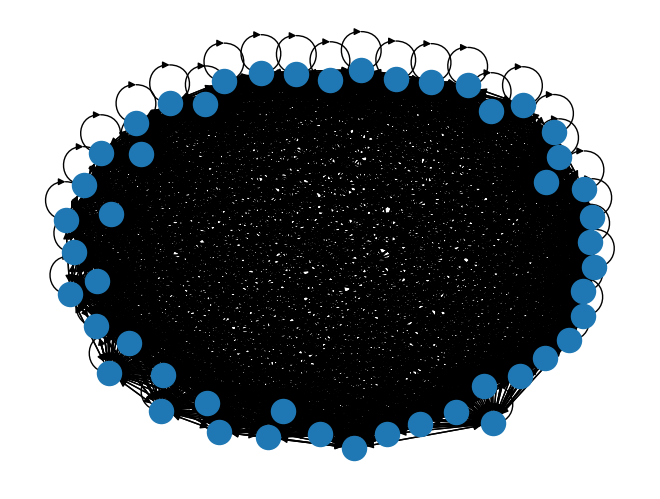

In [ ]:
nx.draw(G)

In [ ]:
adj = pd.DataFrame(data=False, index=closingPrices.columns, columns=closingPrices.columns).astype('bool')

In [ ]:
# bl_data = bn.DataFrame(train_data)
dbn = bn.DBN(data=train_data, lag_order=1)
dbn.learn_structure(algorithm='pc')
dbn.learn_parameters(algorithm='mle')
# predictions = dbn.predict(bl_data.last_row())

# Evaluate the model performance
# mse = np.mean((predictions - bl_data.iloc[-1,:])**2)
# print('Mean squared error:', mse)

AttributeError: module 'bnlearn' has no attribute 'DBN'

In [ ]:
predictions = dbn.predict(test_data)